In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf

### matplotlib 한글 폰트 설정 #############################
from matplotlib import font_manager, rc
## for window #####
font_name = font_manager.FontProperties(fname="/content/drive/MyDrive/malgun.ttf").get_name()
rc('font', family=font_name)
## for mac #####
#rc('font', family='AppleGothic') #for mac

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences

from pprint import pprint
import numpy as np
import os

print(tf.__version__)

2.7.0


In [2]:
sources = [['I', 'feel', 'hungry'],
     ['tensorflow', 'is', 'very', 'difficult'],
     ['tensorflow', 'is', 'a', 'framework', 'for', 'deep', 'learning'],
     ['tensorflow', 'is', 'very', 'fast', 'changing']]
targets = [['나는', '배가', '고프다'],
           ['텐서플로우는', '매우', '어렵다'],
           ['텐서플로우는', '딥러닝을', '위한', '프레임워크이다'],
           ['텐서플로우는', '매우', '빠르게', '변화한다']]

In [3]:
# vocabulary for sources
s_vocab = list(set(sum(sources, [])))
s_vocab.sort()
s_vocab = ['<pad>'] + s_vocab
source2idx = {word : idx for idx, word in enumerate(s_vocab)}
idx2source = {idx : word for idx, word in enumerate(s_vocab)}

pprint(source2idx)

{'<pad>': 0,
 'I': 1,
 'a': 2,
 'changing': 3,
 'deep': 4,
 'difficult': 5,
 'fast': 6,
 'feel': 7,
 'for': 8,
 'framework': 9,
 'hungry': 10,
 'is': 11,
 'learning': 12,
 'tensorflow': 13,
 'very': 14}


In [4]:
# vocabulary for targets
t_vocab = list(set(sum(targets, [])))
t_vocab.sort()
t_vocab = ['<pad>', '<bos>', '<eos>'] + t_vocab
target2idx = {word : idx for idx, word in enumerate(t_vocab)}
idx2target = {idx : word for idx, word in enumerate(t_vocab)}

pprint(target2idx)

{'<bos>': 1,
 '<eos>': 2,
 '<pad>': 0,
 '고프다': 3,
 '나는': 4,
 '딥러닝을': 5,
 '매우': 6,
 '배가': 7,
 '변화한다': 8,
 '빠르게': 9,
 '어렵다': 10,
 '위한': 11,
 '텐서플로우는': 12,
 '프레임워크이다': 13}


In [5]:
def preprocess(sequences, max_len, dic, mode = 'source'):
    assert mode in ['source', 'target'], 'source와 target 중에 선택해주세요.'
    
    if mode == 'source':
        # preprocessing for source (encoder)
        s_input = list(map(lambda sentence : [dic.get(token) for token in sentence], sequences))
        s_len = list(map(lambda sentence : len(sentence), s_input))
        s_input = pad_sequences(sequences = s_input, maxlen = max_len, padding = 'post', truncating = 'post')
        return s_len, s_input
    
    elif mode == 'target':
        # preprocessing for target (decoder)
        # input
        t_input = list(map(lambda sentence : ['<bos>'] + sentence + ['<eos>'], sequences))
        t_input = list(map(lambda sentence : [dic.get(token) for token in sentence], t_input))
        t_len = list(map(lambda sentence : len(sentence), t_input))
        t_input = pad_sequences(sequences = t_input, maxlen = max_len, padding = 'post', truncating = 'post')
        
        # output
        t_output = list(map(lambda sentence : sentence + ['<eos>'], sequences))
        t_output = list(map(lambda sentence : [dic.get(token) for token in sentence], t_output))
        t_output = pad_sequences(sequences = t_output, maxlen = max_len, padding = 'post', truncating = 'post')
        
        return t_len, t_input, t_output

In [6]:
# preprocessing for source
s_max_len = 10
s_len, s_input = preprocess(sequences = sources,
                            max_len = s_max_len, dic = source2idx, mode = 'source')
print(s_len, s_input)

[3, 4, 7, 5] [[ 1  7 10  0  0  0  0  0  0  0]
 [13 11 14  5  0  0  0  0  0  0]
 [13 11  2  9  8  4 12  0  0  0]
 [13 11 14  6  3  0  0  0  0  0]]


In [7]:
# preprocessing for target
t_max_len = 12
t_len, t_input, t_output = preprocess(sequences = targets,
                                      max_len = t_max_len, dic = target2idx, mode = 'target')
print(t_len, t_input, t_output)

[5, 5, 6, 6] [[ 1  4  7  3  2  0  0  0  0  0  0  0]
 [ 1 12  6 10  2  0  0  0  0  0  0  0]
 [ 1 12  5 11 13  2  0  0  0  0  0  0]
 [ 1 12  6  9  8  2  0  0  0  0  0  0]] [[ 4  7  3  2  0  0  0  0  0  0  0  0]
 [12  6 10  2  0  0  0  0  0  0  0  0]
 [12  5 11 13  2  0  0  0  0  0  0  0]
 [12  6  9  8  2  0  0  0  0  0  0  0]]


In [8]:
# hyper-parameters
epochs = 100
batch_size = 4
learning_rate = .005
total_step = epochs / batch_size
buffer_size = 100
n_batch = buffer_size//batch_size
embedding_dim = 32
units = 128

# input
data = tf.data.Dataset.from_tensor_slices((s_len, s_input, t_len, t_input, t_output))
data = data.shuffle(buffer_size = buffer_size)
data = data.batch(batch_size = batch_size)
# s_mb_len, s_mb_input, t_mb_len, t_mb_input, t_mb_output = iterator.get_next()

In [9]:
def gru(units):
    return tf.keras.layers.GRU(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_activation='sigmoid', 
                               recurrent_initializer='glorot_uniform')

In [10]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.enc_units)
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
#         print("state: {}".format(state.shape))
#         print("output: {}".format(state.shape))
              
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [11]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # used for attention
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        # * `score = FC(tanh(FC(EO) + FC(H)))`
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying tanh(FC(EO) + FC(H)) to self.V
        score = self.V(tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis)))
                
        #* `attention weights = softmax(score, axis = 1)`. Softmax by default is applied on the last axis but here we want to apply it on the *1st axis*, since the shape of score is *(batch_size, max_length, 1)*. `Max_length` is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis.
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        # * `context vector = sum(attention weights * EO, axis = 1)`. Same reason as above for choosing axis as 1.
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        # * `embedding output` = The input to the decoder X is passed through an embedding layer.
        x = self.embedding(x)
        
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        # * `merged vector = concat(embedding output, context vector)`
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output shape == (batch_size * 1, vocab)
        x = self.fc(output)
        
        return x, state, attention_weights
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))

In [12]:
encoder = Encoder(len(source2idx), embedding_dim, units, batch_size)
decoder = Decoder(len(target2idx), embedding_dim, units, batch_size)

def loss_function(real, pred):
    mask = 1 - np.equal(real, 0)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
    
#     print("real: {}".format(real))
#     print("pred: {}".format(pred))
#     print("mask: {}".format(mask))
#     print("loss: {}".format(tf.reduce_mean(loss_)))
    
    return tf.reduce_mean(loss_)

# creating optimizer
optimizer = tf.keras.optimizers.Adam()

# creating check point (Object-based saving)
checkpoint_dir = './data_out/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                encoder=encoder,
                                decoder=decoder)

# create writer for tensorboard
summary_writer = tf.summary.create_file_writer(logdir=checkpoint_dir)

In [13]:
for epoch in range(epochs):
    
    hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for i, (s_len, s_input, t_len, t_input, t_output) in enumerate(data):
        loss = 0
        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(s_input, hidden)
            
            dec_hidden = enc_hidden
            
            dec_input = tf.expand_dims([target2idx['<bos>']] * batch_size, 1)
            
            #Teacher Forcing: feeding the target as the next input
            for t in range(1, t_input.shape[1]):
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                
                loss += loss_function(t_input[:, t], predictions)
            
                dec_input = tf.expand_dims(t_input[:, t], 1) #using teacher forcing
                
        batch_loss = (loss / int(t_input.shape[1]))
        
        total_loss += batch_loss
        
        variables = encoder.variables + decoder.variables
        
        gradient = tape.gradient(loss, variables)
        
        optimizer.apply_gradients(zip(gradient, variables))
        
    if epoch % 10 == 0:
        #save model every 10 epoch
        print('Epoch {} Loss {:.4f} Batch Loss {:.4f}'.format(epoch,
                                            total_loss / n_batch,
                                            batch_loss.numpy()))
        checkpoint.save(file_prefix = checkpoint_prefix)

Epoch 0 Loss 0.0396 Batch Loss 0.9900
Epoch 10 Loss 0.0374 Batch Loss 0.9361
Epoch 20 Loss 0.0345 Batch Loss 0.8628
Epoch 30 Loss 0.0331 Batch Loss 0.8279
Epoch 40 Loss 0.0310 Batch Loss 0.7746
Epoch 50 Loss 0.0272 Batch Loss 0.6801
Epoch 60 Loss 0.0181 Batch Loss 0.4531
Epoch 70 Loss 0.0113 Batch Loss 0.2830
Epoch 80 Loss 0.0069 Batch Loss 0.1727
Epoch 90 Loss 0.0040 Batch Loss 0.1008


In [14]:
def evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
#     sentence = preprocess_sentence(sentence)

    inputs = [inp_lang[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang['<bos>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        # storing the attention weigths to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += idx2target[predicted_id] + ' '

        if idx2target.get(predicted_id) == '<eos>':
            return result, sentence, attention_plot
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

# result, sentence, attention_plot = evaluate(sentence, encoder, decoder, source2idx, target2idx,
#                                             s_max_len, t_max_len)

In [15]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [16]:
def translate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    result, sentence, attention_plot = evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
        
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(result))
    
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [17]:
#restore checkpoint

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


Input: I feel hungry
Predicted translation: 나는 배가 고프다 <eos> 


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45208 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45716 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44256 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54532 missing from current font.
  font.set_

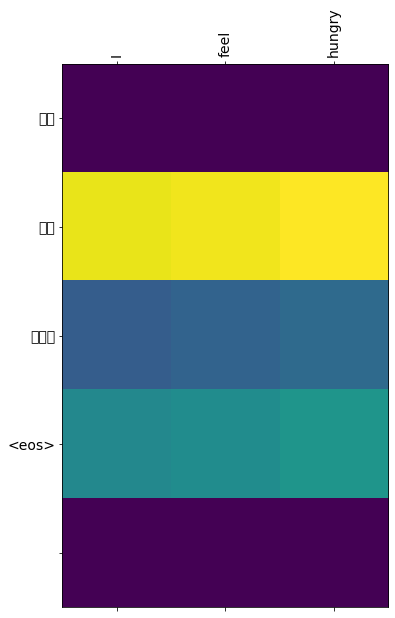

In [18]:
sentence = 'I feel hungry'
# sentence = 'tensorflow is a framework for deep learning'

translate(sentence, encoder, decoder, source2idx, target2idx, s_max_len, t_max_len)